# Graph Classification
- each batch consists of <batch_size> many graphs
- predict graph-level label for each graph


### Batch investigation
DataBatch(edge_index=[2, 144], x=[65, 7], edge_attr=[144, 4], y=[4], batch=[65], ptr=[5])
- batch.edge_index: represents batch by ids of its nodes, 144 edges
- batch.x: node features; 65 nodes, 7 features each
- batch.edge_attr: edge features 144 edges, 4 features each 
- batch.y: graph labels; each of the graphs has one label
- batch.batch: assigns each node to a batch
- batch.ptr: simplified representation of batch.batch


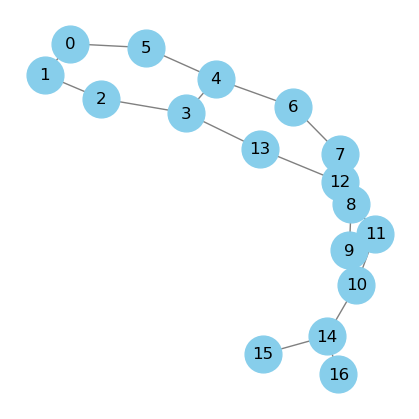

In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx


dataset = TUDataset(root='data/TUDataset', name='MUTAG')
loader = DataLoader(dataset, batch_size=4, shuffle=True)


# visualize the first graph of the batch
batch = next(iter(loader))
graph_idx = 0
node_mask = batch.batch == graph_idx
subgraph_data = batch.clone()
subgraph_data.x = batch.x[node_mask]
subgraph_data.edge_index = batch.edge_index[:, (batch.batch[batch.edge_index[0]] == graph_idx) & (batch.batch[batch.edge_index[1]] == graph_idx)]
G = to_networkx(subgraph_data, to_undirected=True)
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
plt.show()

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from sklearn.metrics import f1_score


class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(GCN, self).__init__()
        # graph convolution
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, hidden_channels)
        self.conv7 = GCNConv(hidden_channels, hidden_channels)
        # MLP for final classification
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # graph convolution
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.relu(self.conv3(x, edge_index))
        x = torch.relu(self.conv4(x, edge_index))
        x = torch.relu(self.conv5(x, edge_index))
        x = torch.relu(self.conv6(x, edge_index))
        x = self.conv7(x, edge_index)
        
        # pool node features on graph level
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x
    

class GAT(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(GAT, self).__init__()
        # graph attention
        self.gat1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        self.gat2= GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        self.gat3 = GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        self.gat4 = GATConv(hidden_channels * 2, hidden_channels, heads=1, concat=False)
        # MLP for final classification
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # graph convolution
        x = torch.relu(self.gat1(x, edge_index))
        x = torch.relu(self.gat2(x, edge_index))
        x = torch.relu(self.gat3(x, edge_index))
        x = self.gat4(x, edge_index)
        # pool node features on graph level
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(model, loader):
    model.eval()
    preds = []
    labels = []
    for batch in loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        preds.append(pred)
        labels.append(batch.y)
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    return f1_score(y_true=labels, y_pred=preds)


def smooth_list(values: list[float], window_size: int = 5) -> list[float]:
    if len(values) < window_size:
        return values  # return original list if it's smaller than the window size
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid').tolist()


In [3]:
# train-test split
test_size = 0.2
split_id = int(len(dataset) * (1 - test_size))
torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:split_id]
test_dataset = dataset[split_id:]

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = GCN(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# train / eval
train_f1s = []
test_f1s = []
losses = []
for epoch in range(1, 51):
    losses.append(train(model, train_loader, optimizer, criterion))
    train_f1s.append(test(model, train_loader))
    test_f1s.append(test(model, test_loader))
train_f1s = smooth_list(train_f1s)
test_f1s = smooth_list(test_f1s)

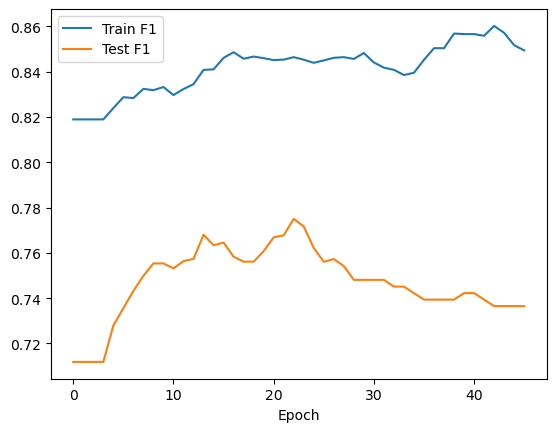

In [4]:
import matplotlib.pyplot as plot

plt.plot(range(len(train_f1s)), train_f1s, label="Train F1")
plt.plot(range(len(test_f1s)), test_f1s, label="Test F1")
plt.xlabel("Epoch")
plt.legend()
plt.show()